<a href="https://colab.research.google.com/github/allnes/age_classifier/blob/master/train_age.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Connect to Google Drive

In [69]:
from google.colab import drive
import os, natsort as nsrt, numpy as np, re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

drive.mount('/content/drive')
PATH_PROJECT='/content/drive/My Drive/DL_DATA_GRAPH/'
PATH_CNN_REPO=PATH_PROJECT + 'BUILD/cnn_graph/'
os.chdir(PATH_CNN_REPO)
from lib import models, graph, coarsening, utils
%ls

# !git clone https://github.com/mdeff/cnn_graph
!git pull origin master

os.chdir(PATH_PROJECT)
%ls
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
lib/         makefile   rcv1.ipynb  requirements.txt  usage.ipynb
LICENSE.txt  nips2016/  README.md   trials/
From https://github.com/mdeff/cnn_graph
 * branch            master     -> FETCH_HEAD
Already up to date.
BUILD/  DATA/


## Preprocessing data

In [89]:
PATH_GRAPHS=PATH_PROJECT + 'DATA/mini_graphs/graphs/'
list_grpahs = []
for (_, _, filenames) in os.walk(PATH_GRAPHS):
    list_grpahs = list_grpahs + filenames

list_grpahs = nsrt.natsorted(list_grpahs)[0::2]

num_samples = int(np.load(PATH_GRAPHS + list_grpahs[0])['num_samples'])
num_features = int(np.load(PATH_GRAPHS + list_grpahs[0])['num_features'])

X = []
for graph_name in list_grpahs:
    raw_graph = np.load(PATH_GRAPHS + graph_name)
    raw_edges = raw_graph['E'].transpose()
    rows = raw_edges[0]
    cols = raw_edges[1]
    raw_data = raw_graph['D']
    sparse_graph = csr_matrix((raw_data, (rows, cols)),
                              shape=(raw_graph['num_features'],
                                     raw_graph['num_features']))
    X.append(sparse_graph)


PATH_LABELS=PATH_PROJECT + 'DATA/mini_graphs/GSE87571_samples.txt'

raw_file = open(PATH_LABELS, 'r')
y = []
for line in raw_file.readlines():
    match_obj = re.match(r'(GSM[0-9]*)\s*([M,F])\s*([0-9]*)\s*([0-9]*)', line)
    if not match_obj is None: 
        y.append(int(match_obj.group(3)))

assert len(y) == num_samples
assert len(X) == num_samples

X = np.asarray(X)
y = np.asarray(y)

print(raw_graph.files)
print(X.shape)
print(y.shape)

['M', 'D', 'E', 'num_samples', 'num_features']
(729,)
(729,)


## Train

d = |V| = 14768, k|V| < |E| = 288694


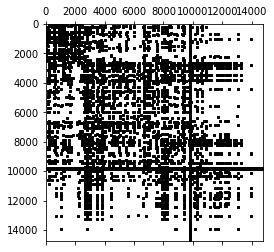

In [94]:
dist, idx = graph.distance_sklearn_metrics(X[0], k=10, metric='euclidean')
A = graph.adjacency(dist, idx).astype(np.float32)

assert A.shape == (num_features, num_features)
print('d = |V| = {}, k|V| < |E| = {}'.format(num_features, A.nnz))
plt.spy(A, markersize=2, color='black')